In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

from itertools import cycle
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from scipy import stats
from numpy import interp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
data = pd.read_excel("dataset/mobile-churn-data.xlsx")

In [7]:
data.describe()

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
count,66469.0,66469.000000,6.646900e+04,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,...,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000
mean,2013.0,6.256721,5.948572e+05,4006.037867,0.040365,63.975718,9.645420,6.845812,0.804450,0.603229,...,98.757451,1.023373,66.910263,3.037600,101.418105,7.318630,62.272684,3.062616,5.931800,0.209225
std,0.0,0.662637,4.292423e+05,6058.350935,0.196815,264.006882,18.473371,14.512993,0.396626,0.489232,...,193.659214,7.409313,149.067804,19.771915,263.280424,35.573779,185.571343,25.071290,76.366818,0.406759
min,2013.0,6.000000,1.300000e+01,0.000000,0.000000,0.000000,0.000000,-30.060000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.0,6.000000,2.501070e+05,457.000000,0.000000,1.000000,0.040000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.0,6.000000,4.135120e+05,1216.000000,0.000000,2.000000,5.270000,2.280000,1.000000,1.000000,...,30.880000,0.000000,15.480000,0.000000,14.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,2013.0,6.000000,1.041120e+06,1985.000000,0.000000,8.000000,12.920000,8.110000,1.000000,1.000000,...,111.650000,0.000000,69.980000,0.000000,96.000000,1.000000,51.000000,0.000000,0.000000,0.000000
max,2013.0,8.000000,1.196944e+06,15947.000000,1.000000,1307.000000,1775.710000,1236.470000,1.000000,1.000000,...,4953.120000,473.250000,4772.370000,1149.120000,18637.000000,2829.000000,13860.000000,4692.000000,5571.220000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66469 entries, 0 to 66468
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        66469 non-null  int64  
 1   month                                       66469 non-null  int64  
 2   user_account_id                             66469 non-null  int64  
 3   user_lifetime                               66469 non-null  int64  
 4   user_intake                                 66469 non-null  int64  
 5   user_no_outgoing_activity_in_days           66469 non-null  int64  
 6   user_account_balance_last                   66469 non-null  float64
 7   user_spendings                              66469 non-null  float64
 8   user_has_outgoing_calls                     66469 non-null  int64  
 9   user_has_outgoing_sms                       66469 non-null  int64  
 10  user_use_g

Data Processing

In [9]:
# Checking for null values
print(data.isnull().sum().sum())

0


Dataset is for the year 2013 so 'year' col is dropped and We do not need 'user_account_id' for the prediction model.

In [10]:
data.drop('year',inplace=True, axis =1)
data.drop('user_account_id',inplace=True, axis =1)

Finding Correlation between Variables

In [11]:
data.corr()

,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
month,1.000000,0.670438,0.213441,-0.085852,-0.171936,-0.151566,-0.477995,-0.381315,-0.032080,0.341644,...,-0.189200,-0.050010,-0.167752,-0.056081,-0.141744,-0.075731,-0.122698,-0.044493,-0.019019,0.476116
user_lifetime,0.670438,1.000000,0.124386,0.314474,-0.219765,-0.220332,-0.648572,-0.534862,-0.081538,0.074515,...,-0.251465,-0.066062,-0.222710,-0.074264,-0.190805,-0.102034,-0.168767,-0.059954,-0.037494,0.529719
user_intake,0.213441,0.124386,1.000000,-0.041898,0.013073,0.019359,0.091288,0.090708,0.091401,0.175389,...,-0.073481,-0.016039,-0.070169,-0.018708,-0.050984,-0.027395,-0.040466,-0.015998,0.008617,-0.014725
user_no_outgoing_activity_in_days,-0.085852,0.314474,-0.041898,1.000000,-0.098636,-0.111340,-0.460601,-0.285890,-0.049772,-0.259467,...,-0.119738,-0.032275,-0.105498,-0.035967,-0.090831,-0.048533,-0.079034,-0.028691,-0.018174,0.222895
user_account_balance_last,-0.171936,-0.219765,0.013073,-0.098636,1.000000,0.174589,0.187376,0.171040,0.050792,0.048383,...,0.154005,0.149941,0.108075,0.177588,0.034485,0.036361,0.025281,0.060304,0.198106,-0.178921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
last_100_sms_outgoing_to_onnet_count,-0.075731,-0.102034,-0.027395,-0.048533,0.036361,0.145103,0.095250,0.159339,0.067636,0.100515,...,0.126281,0.012113,0.131898,0.014260,0.308328,1.000000,0.144752,0.035999,0.055029,-0.089464
last_100_sms_outgoing_to_offnet_count,-0.122698,-0.168767,-0.040466,-0.079034,0.025281,0.356207,0.155355,0.253473,0.091714,0.173922,...,0.174440,0.017490,0.173329,0.014544,0.887187,0.144752,1.000000,0.291214,0.073265,-0.135022
last_100_sms_outgoing_to_abroad_count,-0.044493,-0.059954,-0.015998,-0.028691,0.060304,0.137700,0.054983,0.092850,0.023950,0.057913,...,0.079509,0.214701,0.039252,0.285202,0.346189,0.035999,0.291214,1.000000,0.045440,-0.051195
last_100_gprs_usage,-0.019019,-0.037494,0.008617,-0.018174,0.198106,0.245481,0.033963,0.045829,0.276856,0.043556,...,0.107679,0.084114,0.063750,0.124258,0.092179,0.055029,0.073265,0.045440,1.000000,-0.026421


Heatmap for Correlation

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def heatmap_corr(df, fig_size=20, annot=False, filtering=None, sort=True):
    """
    Generates a correlation heatmap for a given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        fig_size (int): Size of the heatmap figure.
        annot (bool): Whether to display correlation values on heatmap.
        filtering (float): Threshold for filtering high-correlation features.
        sort (bool): Whether to sort and filter features by correlation.
    """

    # Sort and filter correlated features if required
    if sort:
        cols1, cols2, value = [], [], []
        corr_matrix = df.corr()

        # Collect all correlation pairs
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                cols1.append(corr_matrix.columns[i])
                cols2.append(corr_matrix.columns[j])
                value.append(corr_matrix.iloc[i, j])

        corr_pairs_df = pd.DataFrame({
            'column_1': cols1,
            'column_2': cols2,
            'corr': value
        }).sort_values('corr', ascending=False)

        # Apply filtering if specified
        if filtering is not None:
            corr_pairs_df = corr_pairs_df[abs(corr_pairs_df['corr']) >= filtering]

        # Extract unique relevant columns
        selected_cols = pd.unique(corr_pairs_df[['column_1', 'column_2']].values.ravel('K'))
        data_for_heatmap = df[selected_cols]
    else:
        data_for_heatmap = df.copy()

    # Plot the heatmap
    plt.figure(figsize=(fig_size, fig_size))
    colormap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(
        data_for_heatmap.corr(),
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': 0.75, 'orientation': 'vertical'},
        annot=annot,
        fmt=".2f",
        linewidths=0.5,
        linecolor='white',
        vmin=-1,
        vmax=1,
        annot_kws={'fontsize': 10}
    )

    plt.title("Correlation Heatmap", fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

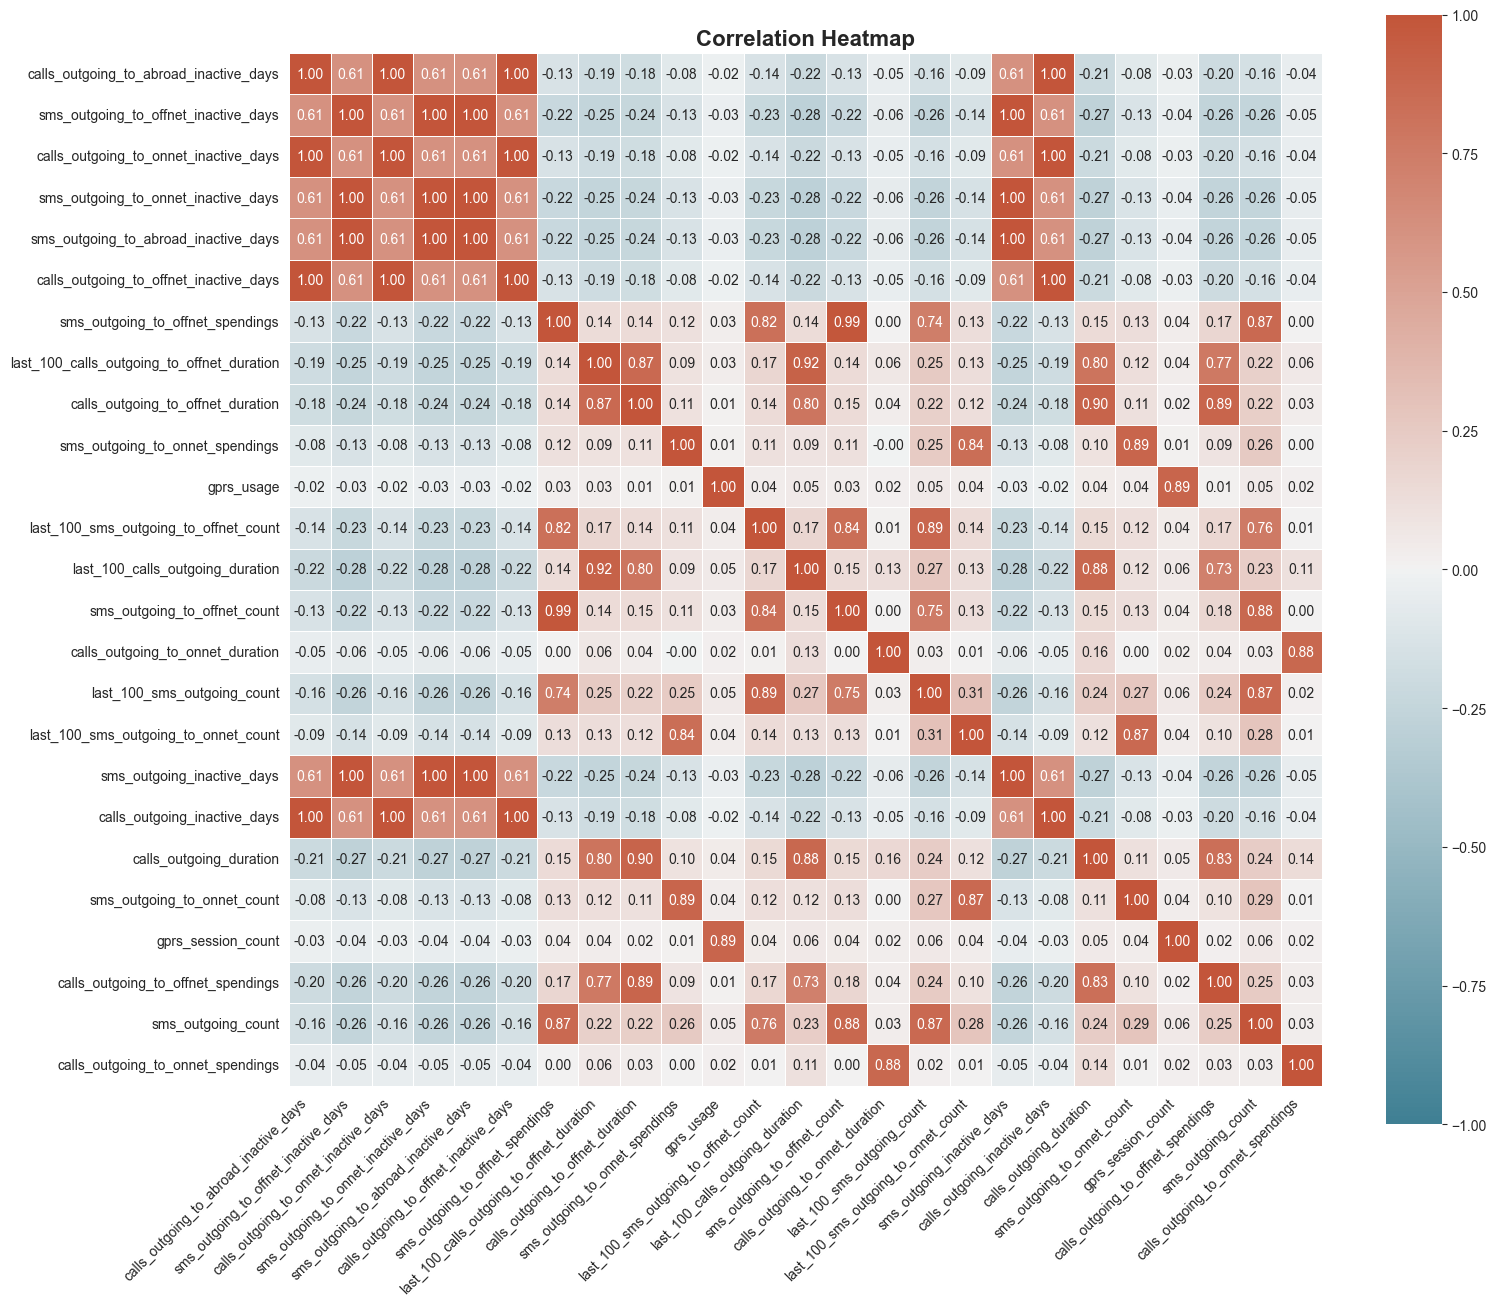

In [18]:
heatmap_corr(data, sort=True, filtering=0.85, annot=True, fig_size=16)

Columns with correlation > 0.85 will be dropped:


Reason:    We remove highly correlated features to avoid confusing the model with similar information. When two features are too alike, it can make it hard for the model to understand which one really matters. This can lead to poor predictions. By dropping one of them, we simplify the data, reduce the chance of overfitting, and make the model easier to interpret.

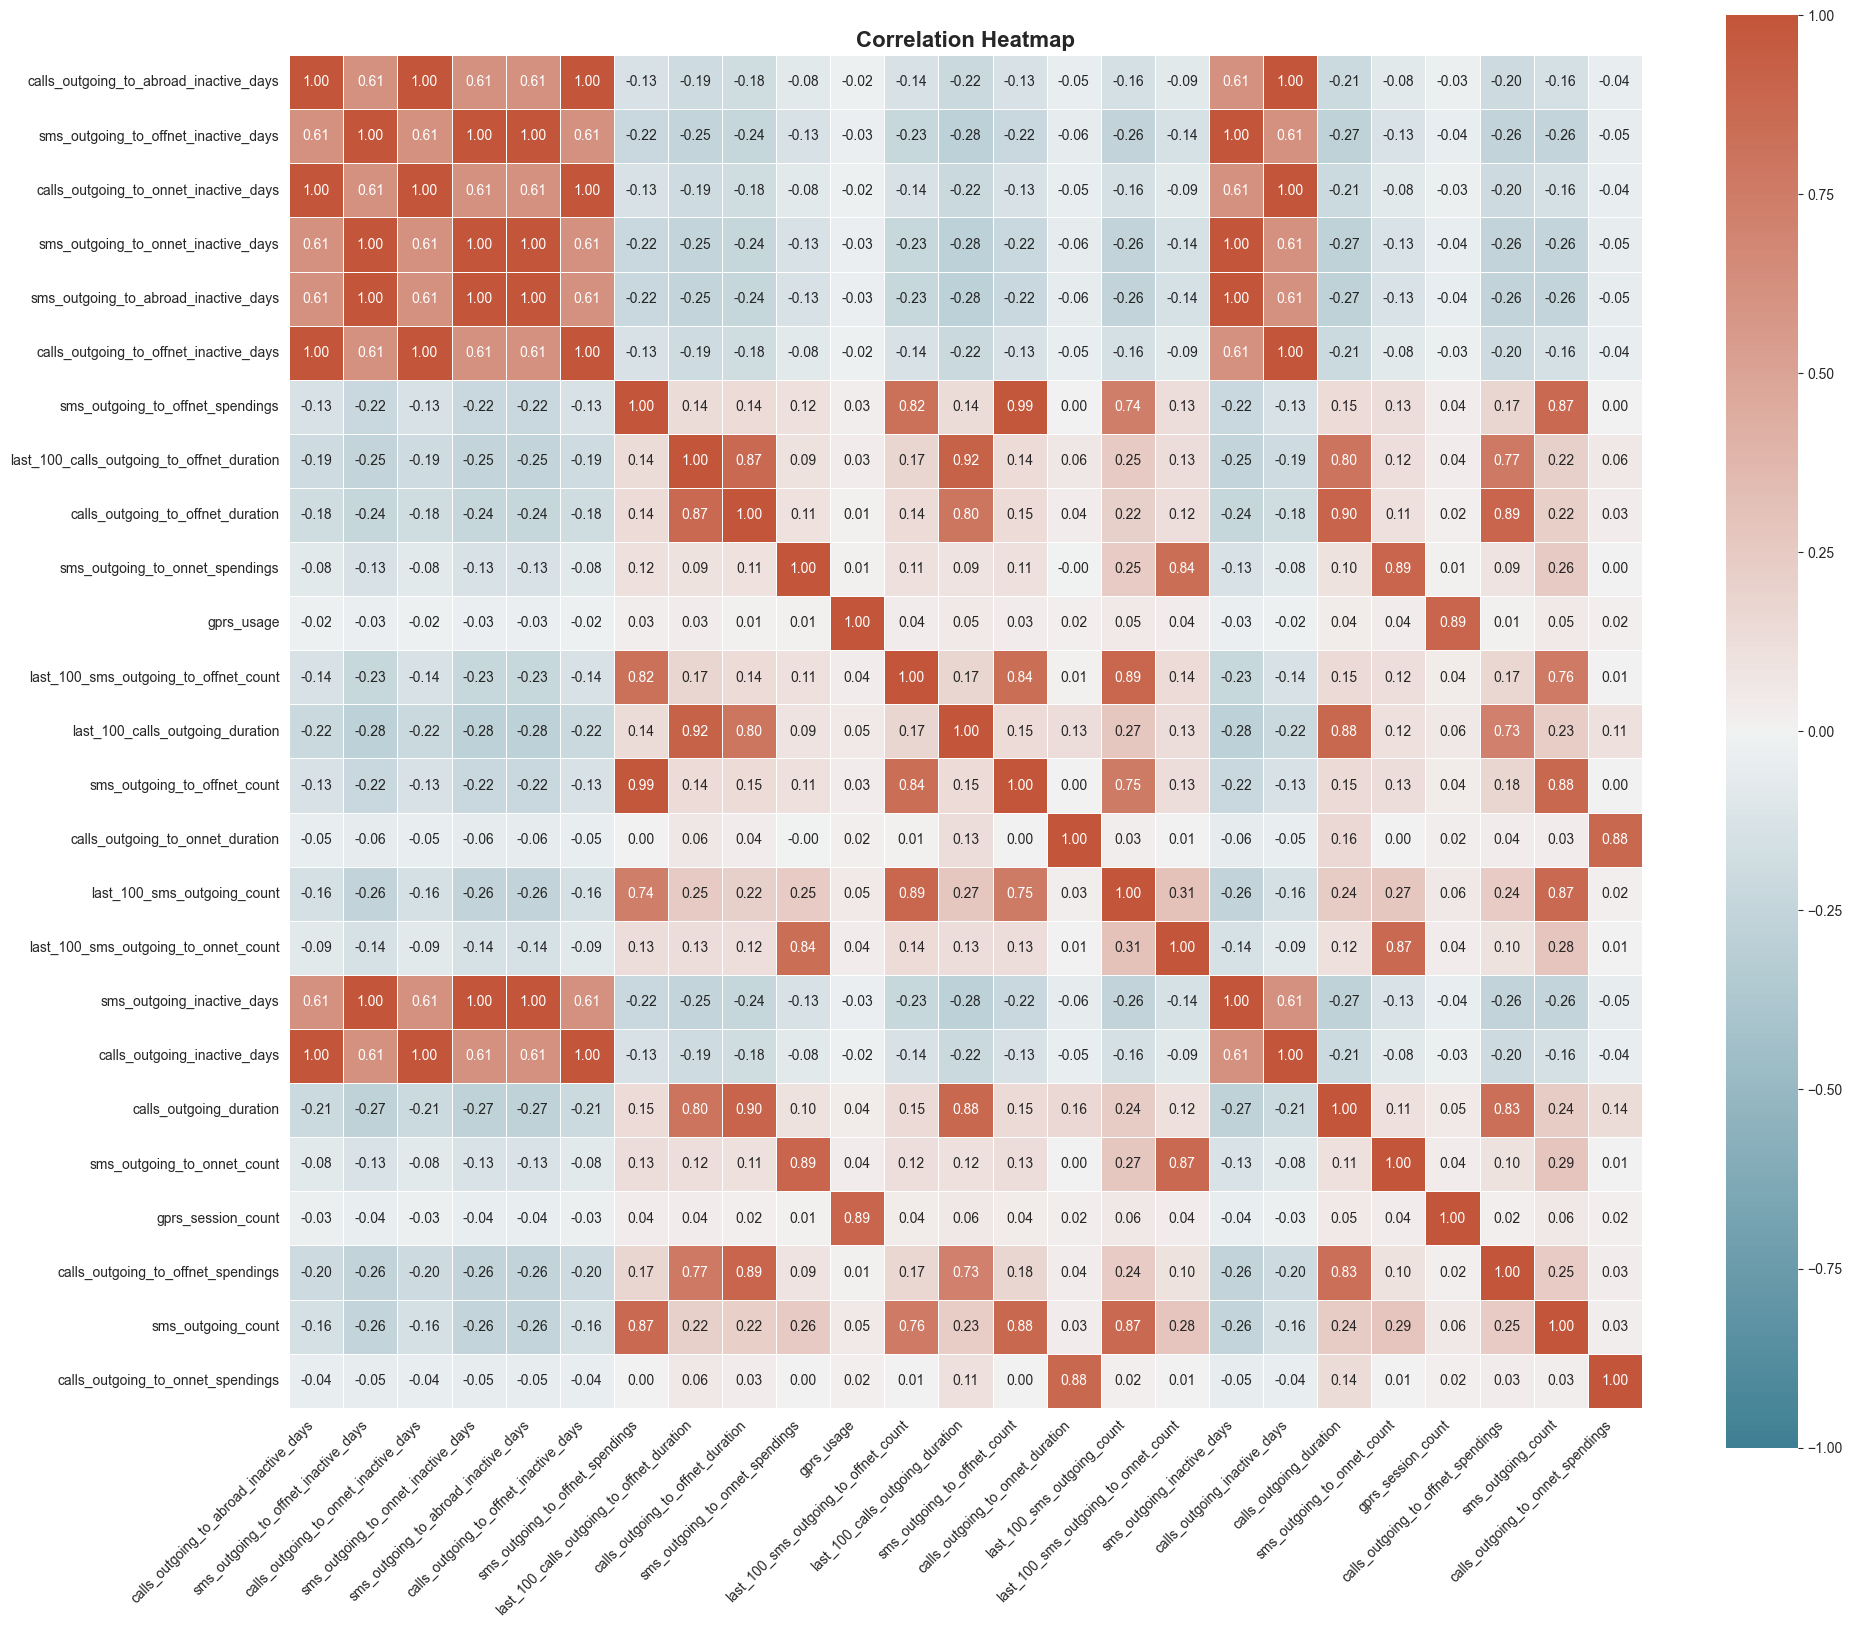

In [19]:
heatmap_corr(data, sort = True, annot = True, filtering = 0.85)

Extracting Columns with Corr more than 85%

In [20]:
cols1=[]
cols2=[]
corr_mat = data.corr()
value=[]

for i in range(len(corr_mat.columns)):
    for j in range(i):
        cols1.append(corr_mat.columns[i])
        cols2.append(corr_mat.columns[j])
        value.append(corr_mat.iloc[i,j])


corr_col = pd.DataFrame({'Feature Name 1': cols1, 'Feature Name 2': cols2, 'Correlation':value})
corr_col.sort_values('Correlation',ascending=False, inplace=True)
corr_col.reset_index(drop=True, inplace=True)
corr_col = corr_col[corr_col['Correlation'] > 0.85]
corr_col['Feature Name 1'].unique()

array(['calls_outgoing_to_abroad_inactive_days',
       'sms_outgoing_to_offnet_inactive_days',
       'calls_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_abroad_inactive_days',
       'calls_outgoing_to_offnet_inactive_days',
       'sms_outgoing_to_offnet_spendings',
       'last_100_calls_outgoing_to_offnet_duration',
       'calls_outgoing_to_offnet_duration',
       'sms_outgoing_to_onnet_spendings', 'gprs_usage',
       'last_100_sms_outgoing_to_offnet_count',
       'last_100_calls_outgoing_duration', 'sms_outgoing_to_offnet_count',
       'calls_outgoing_to_onnet_duration', 'last_100_sms_outgoing_count',
       'last_100_sms_outgoing_to_onnet_count'], dtype=object)

Dropping columns with Corr more than 85%

In [21]:
data.drop(['calls_outgoing_to_abroad_inactive_days',
       'sms_outgoing_to_offnet_inactive_days',
       'calls_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_abroad_inactive_days',
       'calls_outgoing_to_offnet_inactive_days',
       'sms_outgoing_to_offnet_spendings',
       'last_100_calls_outgoing_to_offnet_duration',
       'calls_outgoing_to_offnet_duration',
       'sms_outgoing_to_onnet_spendings', 'gprs_usage',
       'last_100_sms_outgoing_to_offnet_count',
       'last_100_calls_outgoing_duration', 'sms_outgoing_to_offnet_count',
       'calls_outgoing_to_onnet_duration', 'last_100_sms_outgoing_count',
       'last_100_sms_outgoing_to_onnet_count'], inplace = True, axis =1)

EDA

In [22]:
data.describe()

,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,gprs_session_count,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
count,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,...,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000
mean,6.256721,4006.037867,0.040365,63.975718,9.645420,6.845812,0.804450,0.603229,0.045074,0.560246,...,6.329492,0.197343,1187.918097,3.347500,21.900539,1.023373,3.037600,3.062616,5.931800,0.209225
std,0.662637,6058.350935,0.196815,264.006882,18.473371,14.512993,0.396626,0.489232,0.207467,0.496361,...,94.147863,2.855731,334.434914,6.014605,44.909632,7.409313,19.771915,25.071290,76.366818,0.406759
min,6.000000,0.000000,0.000000,0.000000,0.000000,-30.060000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-38.900000,0.000000,0.000000,-17.239000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,457.000000,0.000000,1.000000,0.040000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1276.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1216.000000,0.000000,2.000000,5.270000,2.280000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1276.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,1985.000000,0.000000,8.000000,12.920000,8.110000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1276.000000,4.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,15947.000000,1.000000,1307.000000,1775.710000,1236.470000,1.000000,1.000000,1.000000,1.000000,...,9024.000000,255.400000,1338.000000,236.000000,3000.000000,473.250000,1149.120000,4692.000000,5571.220000,1.000000


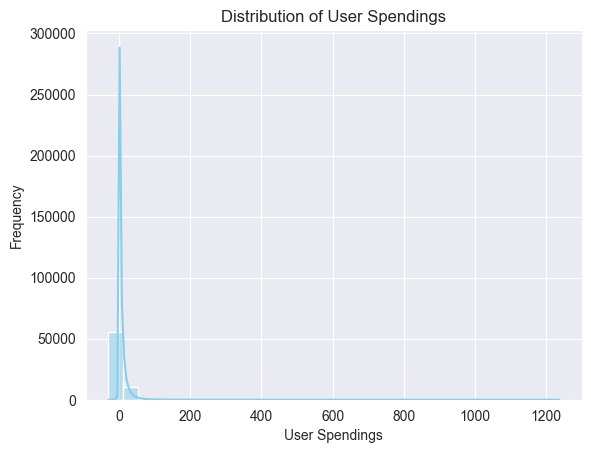

In [23]:
sns.histplot(data['user_spendings'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of User Spendings')
plt.xlabel('User Spendings')
plt.ylabel('Frequency')
plt.show()

Log Transform the data to reduce skewness for better model performance:

<Axes: xlabel='log_user_spendings', ylabel='Count'>

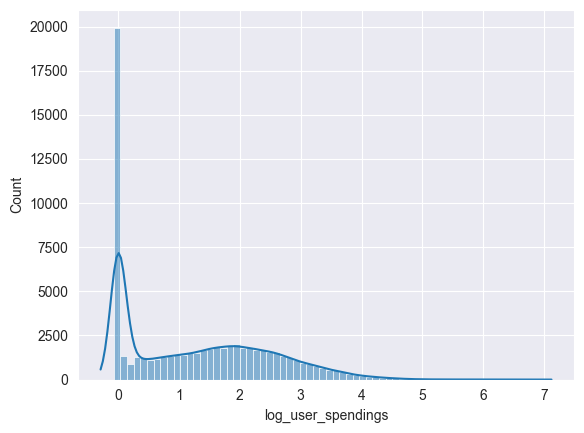

In [24]:
data['log_user_spendings'] = np.log1p(data['user_spendings'])
sns.histplot(data['log_user_spendings'], kde=True)

Most users spend very little. Most between 0 and 100

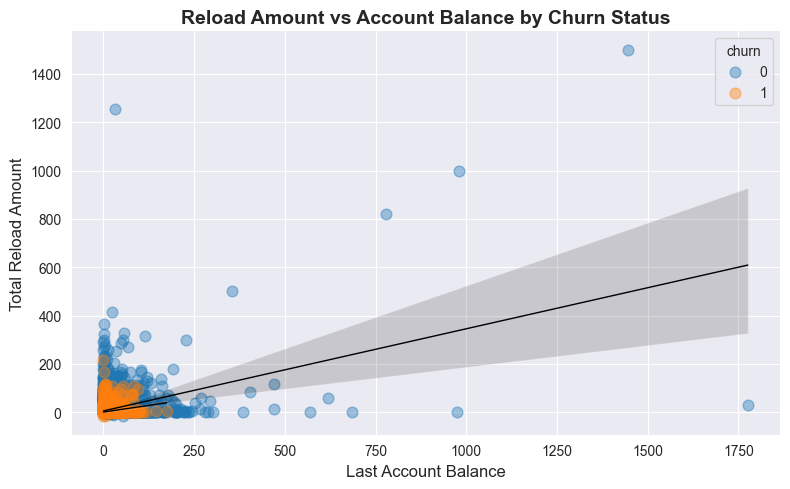

In [25]:
sns.lmplot(
    x='user_account_balance_last',
    y='reloads_sum',
    data=data,
    hue='churn',
    height=5,
    aspect=1.6,
    legend_out=False,
    scatter_kws={"s": 60, "alpha": 0.4},
    line_kws={"color": "black", "linewidth": 1}
)

plt.title('Reload Amount vs Account Balance by Churn Status', fontsize=14, weight='bold')
plt.xlabel('Last Account Balance', fontsize=12)
plt.ylabel('Total Reload Amount', fontsize=12)
plt.tight_layout()
plt.show()

The scatter plot shows that churned customers (orange) typically have low balances and rarely reload, suggesting low engagement or loss of interest.
In contrast, loyal customers (blue) maintain higher balances and reload more often, indicating stronger usage and commitment.
Overall, higher spending and reload activity correlate with lower churn risk.

Actionable Recommendations:

Target low-balance, low-reload users with timely offers or reminders to reload before they drop off.Focus retention efforts on high-value users who are already engaged, to keep them loyal.

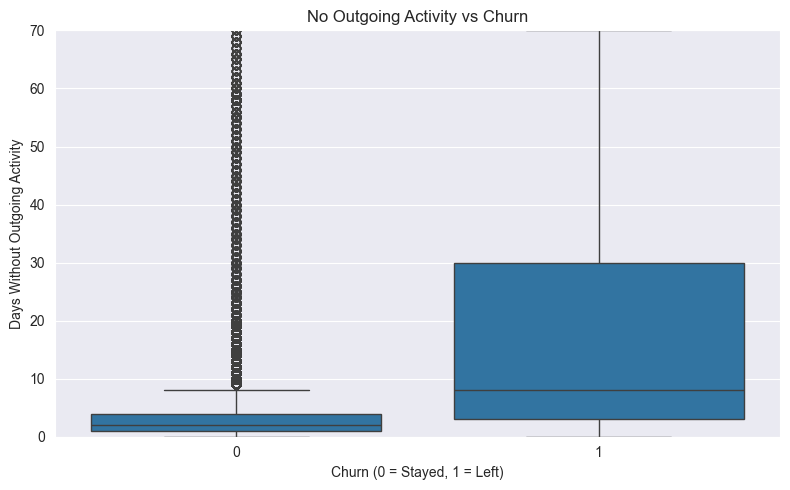

In [34]:
f, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    x='churn',
    y='user_no_outgoing_activity_in_days',
    data=data,
    ax=ax
)

ax.set_ylim(0, 70)
ax.set_title('No Outgoing Activity vs Churn')
ax.set_xlabel('Churn (0 = Stayed, 1 = Left)')
ax.set_ylabel('Days Without Outgoing Activity')
plt.tight_layout()
plt.show()

USERS WITH MORE NO OUTGOING ACTIVITY ARE MORE LIKELY TO CHURN


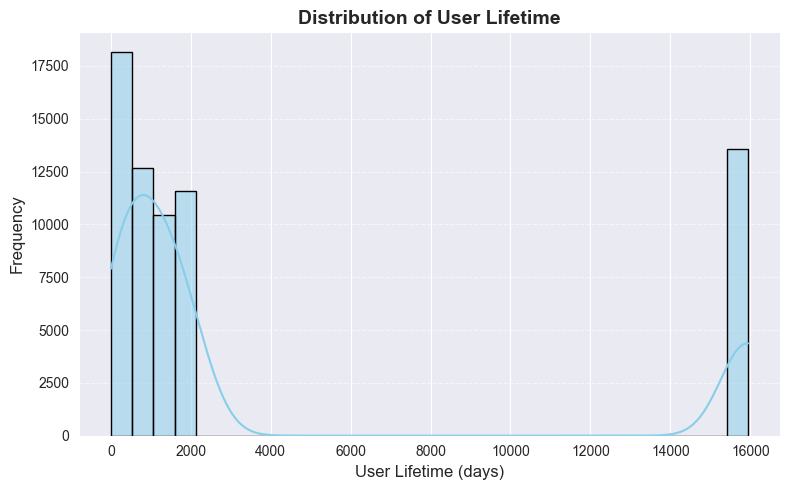

In [46]:

plt.figure(figsize=(8, 5))
sns.histplot(
    data['user_lifetime'],
    bins=30,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

plt.title('Distribution of User Lifetime', fontsize=14, weight='bold')
plt.xlabel('User Lifetime (days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Most users have been active for less than 2,000 days, indicating a relatively young customer base.

Action: Focus on retaining newer users early, while nurturing long-term users with loyalty perks.

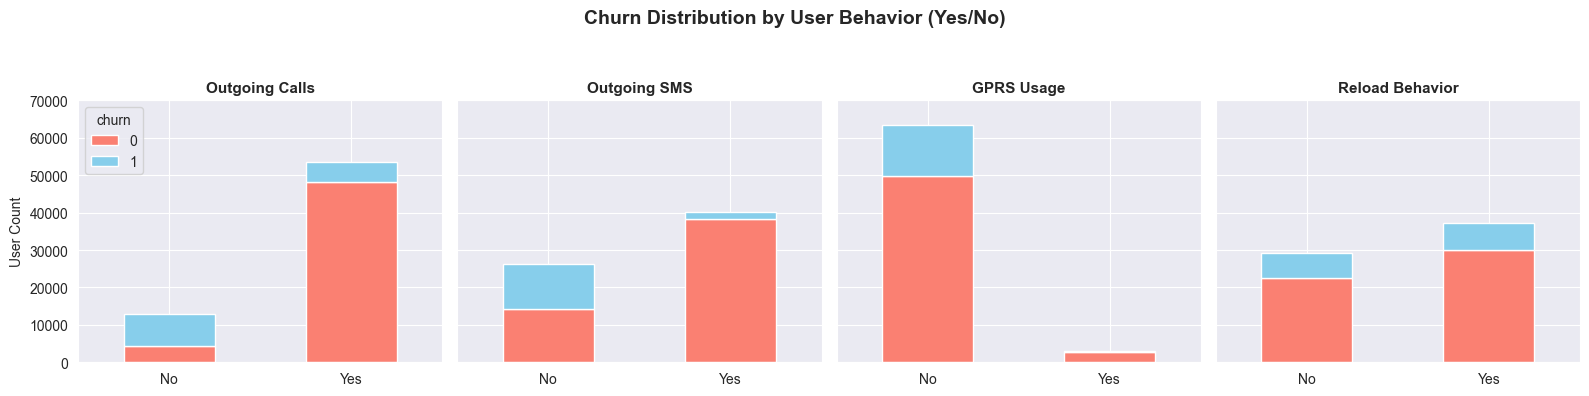

In [47]:
# Select and rename categorical columns
cat = data[['user_has_outgoing_calls', 'user_has_outgoing_sms', 'user_use_gprs', 'user_does_reload', 'churn']].copy()

# Map binary values to Yes/No for clarity
binary_map = {0: 'No', 1: 'Yes'}
cat['user_has_outgoing_calls'] = cat['user_has_outgoing_calls'].map(binary_map)
cat['user_has_outgoing_sms']   = cat['user_has_outgoing_sms'].map(binary_map)
cat['user_use_gprs']           = cat['user_use_gprs'].map(binary_map)
cat['user_does_reload']        = cat['user_does_reload'].map(binary_map)
cat['indx'] = cat.index

# Create pivot tables
pivot_tables = {
    "Outgoing Calls": cat.pivot_table(index='user_has_outgoing_calls', columns='churn', values='indx', aggfunc='count'),
    "Outgoing SMS": cat.pivot_table(index='user_has_outgoing_sms', columns='churn', values='indx', aggfunc='count'),
    "GPRS Usage": cat.pivot_table(index='user_use_gprs', columns='churn', values='indx', aggfunc='count'),
    "Reload Behavior": cat.pivot_table(index='user_does_reload', columns='churn', values='indx', aggfunc='count'),
}

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for i, (title, table) in enumerate(pivot_tables.items()):
    table.plot(kind='bar', stacked=True, ax=axes[i], color=['salmon', 'skyblue'])
    axes[i].set_title(title, fontsize=11, weight='bold')
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].set_ylim(0, 70000)
    axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_ylabel("User Count")
    else:
        axes[i].get_legend().remove()

plt.suptitle("Churn Distribution by User Behavior (Yes/No)", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Insights from User Behavior vs Churn Distribution
1.	Users with no outgoing calls are much more likely to churn, making user_has_outgoing_calls a strong indicator of churn risk.
2. Users who send SMS and use GPRS(Mobile Data) are less likely to churn, suggesting that regular interaction with the network (via data or messaging) reflects higher engagement and loyalty.
3. Reload behavior (user_does_reload) does not clearly distinguish churners from non-churners—the churn rate is fairly balanced between users who do and don’t reload.


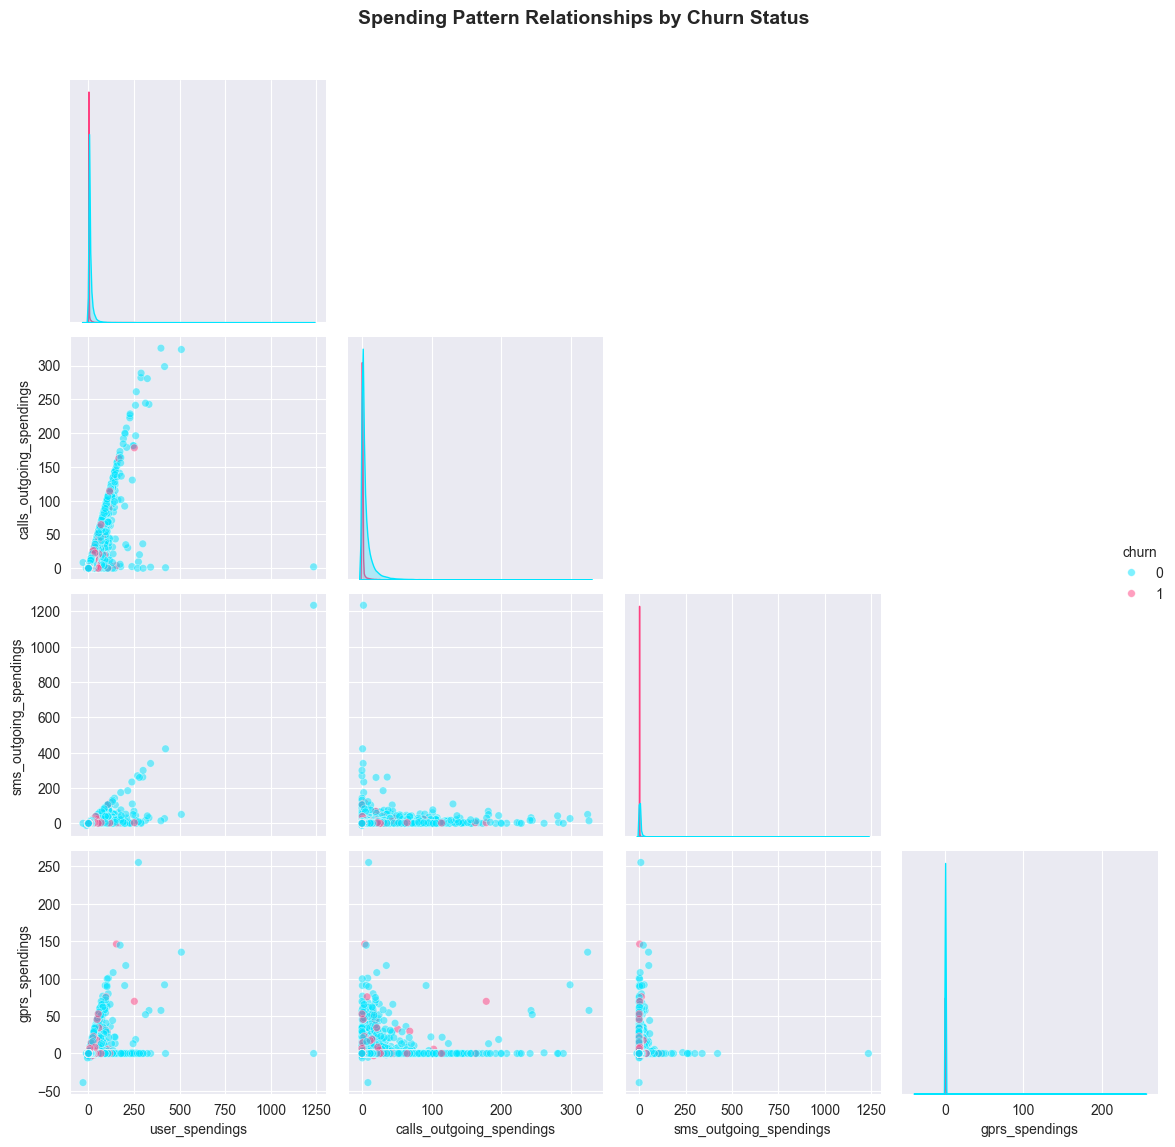

In [53]:
# Updated pairplot with better visuals
sns.pairplot(
    data[['user_spendings', 'calls_outgoing_spendings', 'sms_outgoing_spendings', 'gprs_spendings', 'churn']],
    hue='churn',
    height=2.8,
    palette={0: '#00e5ff', 1: '#ff4081'},  # Bright Cyan vs Hot Pink
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 30},
    corner=True
)

plt.suptitle("Spending Pattern Relationships by Churn Status", y=1.02, fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### Spending Pattern Insights by Churn Status

The pairplot above visualizes the relationship between different types of user spendings (calls, SMS, GPRS(Data Usage), total) and churn status (`0` = Stayed, `1` = Left).

#### Business Insights:

- **Overall Spending is Low:** Most users, regardless of churn status, spend relatively little across all services. The majority of points cluster near **zero**, with a few high outliers.

- **Churned Users Are Less Engaged:**
  - Users who churned (pink) show **lower levels of activity** across spending types.
  - Their presence is **sparser** in higher spending zones for calls, SMS, and GPRS.

- **Call Spendings Have a Positive Relationship with Total Spendings:**
  - There’s a visible upward trend between `user_spendings` and `calls_outgoing_spendings`, especially for non-churned users.
  - This suggests users who make calls contribute significantly to overall spend and are **less likely to churn**.

- **High Spenders Rarely Churn:**
  - Users with **higher SMS and GPRS spendings** are almost exclusively non-churners (blue), indicating **high engagement = higher retention**.

- **GPRS and SMS Spending Show Little Correlation with Each Other**, but both are low for most churned users.

#### Business Recommendation:
- Focus on retaining users with **low or no spending**, especially in early stages.
- Encourage activity via **call, SMS, or data bundles** — these are tied to customer retention.
- Consider **rewards for consistent usage** to nudge low spenders into higher engagement brackets.

In [54]:
data['churn'].value_counts()

churn
0    52562
1    13907
Name: count, dtype: int64

The `churn` column is **imbalanced**, with a significantly higher number of non-churners compared to churners:

- **Non-Churners (0):** 52,562 users
- **Churners (1):** 13,907 users

In [58]:
data2 = data.drop(columns=['log_user_spendings'])

KeyError: "['log_user_spending'] not found in axis"

In [67]:

data2 = data2.dropna()
print(data2)


       month  user_lifetime  user_intake  user_no_outgoing_activity_in_days  \
0          6           1000            0                                  1   
1          6           1000            0                                 25   
2          6           1005            0                                  8   
3          6           1013            0                                 11   
4          6           1032            0                                  2   
...      ...            ...          ...                                ...   
66464      8          15947            0                                  1   
66465      8          15947            0                                  1   
66466      8          15947            0                                  1   
66467      8          15947            0                                  1   
66468      8              1            1                                  1   

       user_account_balance_last  user_spendings  u

### Splitting Data for Model Training

In [69]:
y = data2['churn']
data2.drop('churn',inplace=True, axis =1)
x = data2

## The dataset is split into **training** and **testing** sets using `train_test_split()`, with **70% for training** and **30% for testing**.

In [70]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

# Standardizing Dataset
#### Standardizing Features
1. Standardization scales features to have zero mean and unit variance, crucial for models sensitive to the magnitude of features.
2. For some models require it for proper functionality.


In [71]:
train_scaler = StandardScaler()
x_train_std = train_scaler.fit_transform(x_train)

test_scaler = StandardScaler()
x_test_std = test_scaler.fit_transform(x_test)

#### Checking Pre-Oversampling Dataset Shape
We examine the shape of our training data to understand the scale of our dataset before applying any resampling techniques.

In [72]:
# BEFORE OVERSAMPLING X TRAIN SHAPE
np.shape(x_train_std)

(46528, 46)

In [73]:
# BEFORE OVERSAMPLING Y TRAIN SHAPE
np.shape(y_train)

(46528,)

#### Checking Class Distribution Before Oversampling
It's important to view the initial class distribution to gauge the extent of class imbalance in our target variable `y`.

In [74]:
# IMBALANCE IN OUR CLASSES BEFORE OVERSAMPLING

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 36763]
 [    1  9765]]


#### Applying SMOTE for Oversampling
SMOTE (Synthetic Minority Over-sampling Technique) is used here to address class imbalance by generating synthetic samples for the minority class.

In [75]:
# IMPLEMENTING SMOTE

smote = SMOTE(sampling_strategy=0.6)
x_sm, y_sm = smote.fit_resample(x_train_std,y_train)


#### Checking Dataset Shape After Oversampling
Post-oversampling, we review the new shape of our dataset to confirm that oversampling has modified the data as expected.

In [76]:
# AFTER OVERSAMPLING X TRAIN SHAPE

np.shape(x_sm)

(58820, 46)


#### Checking Class Distribution After Oversampling
Evaluating the class balance after applying SMOTE helps us ensure that the target classes are now more evenly represented.

In [77]:
# AFTER OVERSAMPLING Y TRAIN SHAPE

np.shape(y_sm)

(58820,)


#### Summary of Class Balancing
This comment reflects on the success of SMOTE in balancing the classes, which is crucial for building a model that performs well on all classes.

In [78]:
# CLASSES AFTER OVERSAMPLING

unique, counts = np.unique(y_sm, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 36763]
 [    1 22057]]


#### SO AFTER IMPLEMENTING SMOTE OUR Y VARIABLE IS SOMEWHAT BALANCED.

In [79]:
# List of classifier models to be evaluated
classifier_models = [
    linear_model.LogisticRegressionCV(),
    naive_bayes.GaussianNB(),
    svm.SVC(kernel='rbf'),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    XGBClassifier(),
]

# Configuration for cross-validation
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0)

# DataFrame to compare the metrics of each model
metrics_columns = ['Name', 'Accuracy', 'Recall', 'Precision', 'F1_score']
model_performance = pd.DataFrame(columns=metrics_columns)

# Loop through each model to evaluate performance
for index, model in enumerate(classifier_models):
    model_name = model.__class__.__name__
    model_performance.loc[index, 'Name'] = model_name

    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Perform cross-validation
    cv_results = model_selection.cross_validate(model, x_sm, y_sm, cv=cv_split, scoring=scoring, n_jobs=-1)

    # Collect average results
    model_performance.loc[index, 'Fit Time'] = cv_results['fit_time'].mean()
    model_performance.loc[index, 'Accuracy'] = cv_results['test_accuracy'].mean()
    model_performance.loc[index, 'Recall'] = cv_results['test_recall'].mean()
    model_performance.loc[index, 'Recall_STD'] = cv_results['test_recall'].std()
    model_performance.loc[index, 'Precision'] = cv_results['test_precision'].mean()
    model_performance.loc[index, 'F1_score'] = cv_results['test_f1_score'].mean()

    print(cv_results['fit_time'].mean(), '==>  ', model_name, 'is done!')

# Sort the results table by the Recall metric
model_performance.sort_values(by=['Recall'], ascending=False, inplace=True)

# Display the performance comparison
model_performance

1.7363014698028565 ==>   LogisticRegressionCV is done!
0.06757094860076904 ==>   GaussianNB is done!
56.86457233428955 ==>   SVC is done!
0.46775403022766116 ==>   LinearSVC is done!
0.5212021112442017 ==>   DecisionTreeClassifier is done!
2.395769953727722 ==>   AdaBoostClassifier is done!
10.435933780670165 ==>   GradientBoostingClassifier is done!
4.659994339942932 ==>   RandomForestClassifier is done!
0.46309614181518555 ==>   XGBClassifier is done!


,Name,Accuracy,Recall,Precision,F1_score,Fit Time,Recall_STD
1,GaussianNB,0.611005,0.940794,0.490867,0.645113,0.067571,0.002846
8,XGBClassifier,0.889805,0.871,0.841354,0.855915,0.463096,0.003305
6,GradientBoostingClassifier,0.876193,0.845127,0.82881,0.836874,10.435934,0.004379
4,DecisionTreeClassifier,0.845676,0.833737,0.773319,0.80238,0.521202,0.004114
7,RandomForestClassifier,0.88008,0.827445,0.849539,0.83833,4.659994,0.005313
5,AdaBoostClassifier,0.846373,0.799225,0.793479,0.796329,2.395770,0.003515
2,SVC,0.843098,0.766747,0.806387,0.785945,56.864572,0.013106
0,LogisticRegressionCV,0.837476,0.755683,0.800665,0.777495,1.736301,0.005989
3,LinearSVC,0.837108,0.738062,0.811449,0.772982,0.467754,0.007521


### 🚀XGBoost is Our Model of Choice

XGBoost has demonstrated superior performance on our dataset, showing the best balance between recall and precision with considerable efficiency during the training phase. Here's why it stands out:

#### Key Advantages of XGBoost:
- **High Performance:** Achieves higher accuracy and better classification metrics compared to other models.
- **Speed and Efficiency:** Fast execution time makes it suitable for high-volume and real-time prediction environments.
- **Robust to Overfitting:** Thanks to its built-in regularization which helps improve model's generalization.

#### Business Implications:
- **Reliable Predictions:** Essential for critical business decisions where accuracy can dictate customer retention and risk management.
- **Scalability:** Handles large-scale data effortlessly, ensuring the model remains effective as data grows.
- **Versatility:** Adapts to various types of predictive modeling tasks, making it a valuable tool across different departments.

Considering these points, XGBoost not only meets our accuracy and efficiency criteria but also aligns well with strategic business objectives aiming for growth and sustainability.

In [90]:

# Define the search space for hyperparameters
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,  # fixed number of estimators
    'seed': 0
}

def objective(space):
    # Create an XGBoost classifier with hyperparameters from the search space
    clf = xgb.XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        eval_metric='auc',  # Moved to the constructor
        seed=int(space['seed'])
    )

    # Define the evaluation sets (training and testing datasets)
    evaluation = [(x_sm, y_sm), (x_test_std, y_test)]

    # Fit the model without early_stopping_rounds if it causes issues
    clf.fit(x_sm, y_sm,
            eval_set=evaluation,
            verbose=False)

    # Make predictions on the standardized test set
    pred = clf.predict(x_test_std)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, pred)
    print("SCORE:", accuracy, "==>", clf.__class__.__name__)

    # Return the loss (negative accuracy because Hyperopt minimizes) and the status
    return {'loss': -accuracy, 'status': STATUS_OK}

# Initialize a Trials object to store hyperopt results
trials = Trials()

# Run hyperparameter optimization using Hyperopt
best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)



SCORE:                                                 
0.7781956772478813                                     
==>                                                    
XGBClassifier                                          
SCORE:                                                                            
0.7940424251542049                                                                
==>                                                                               
XGBClassifier                                                                     
SCORE:                                                                            
0.8386239406248432                                                                
==>                                                                               
XGBClassifier                                                                     
SCORE:                                                                            
0.6182739080286846           

In [91]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': np.float64(0.8999267183269687), 'gamma': np.float64(8.109204609180658), 'max_depth': np.float64(16.0), 'min_child_weight': np.float64(2.0), 'reg_alpha': np.float64(180.0), 'reg_lambda': np.float64(0.8424710134501358)}


In [92]:
params = {'colsample_bytree': 0.8999267183269687,
          'gamma': 8.109204609180658,
          'max_depth': 16,
          'min_child_weight': 2,
          'reg_alpha': 180.0,
          'reg_lambda': 0.8424710134501358,
          'objective': 'binary:logistic',  # Corrected the objective for binary classification
          'eval_metric': 'logloss',  # Use 'logloss' for binary classification
          'random_state': 42}

#### TRAINING XGBOOST WITH BEST PARAMETERS ON WHOLE TRAINING DATASET

In [93]:
XGB = xgb.XGBClassifier(**params)


In [94]:
XGB.fit(x_sm, y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8999267183269687, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=8.109204609180658, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [95]:
# TRAINING ACCURACY
XGB.score(x_sm, y_sm)

0.8538252295137708

In [96]:
# TEST ACCURACY
XGB.score(x_test_std, y_test)

0.8594353342359962

In [97]:
y_predict = XGB.predict(x_test_std)
y_true = pd.Series(y_test).map({0: 'No', 1: 'Yes'}).to_numpy()
y_pred = pd.Series(y_predict).map({0: 'No', 1: 'Yes'}).to_numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          No       0.94      0.88      0.91     15799
         Yes       0.63      0.77      0.70      4142

    accuracy                           0.86     19941
   macro avg       0.78      0.83      0.80     19941
weighted avg       0.87      0.86      0.86     19941



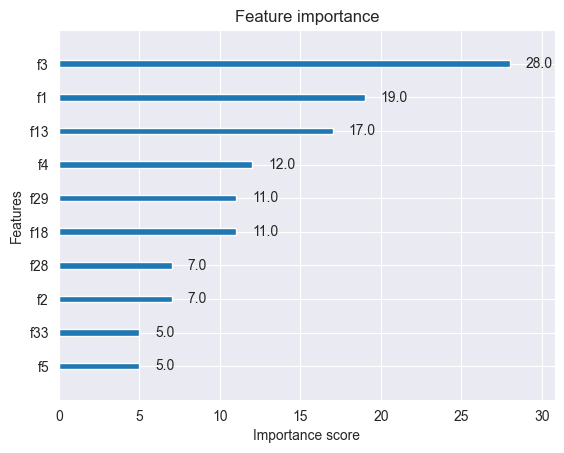

In [98]:
plot_importance(XGB, max_num_features=10)
plt.show()


In [100]:
# MOST IMPORTANT FEATURES WE GET ARE

ls = [1, 3, 18, 4, 13, 40, 29, 33, 35, 2]
i = 0
for col in data.columns:
    if i in ls:
        print(col)
    i = i + 1

user_lifetime
user_intake
user_no_outgoing_activity_in_days
user_account_balance_last
calls_outgoing_count
calls_outgoing_inactive_days
sms_outgoing_inactive_days
sms_incoming_count
sms_incoming_from_abroad_count
last_100_reloads_count


In [107]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# Assuming 'train_scaler' was trained on the original training set 'x_train'
print("Features expected by scaler:", x_train.columns.tolist())

# Define new sample data making sure to match the expected features
data_dict = {
    'user_lifetime': [500],
    'user_intake': [20],
    'user_no_outgoing_activity_in_days': [15],
    'user_account_balance_last': [200],
    'calls_outgoing_count': [50],
    'calls_outgoing_inactive_days': [5],
    'sms_outgoing_inactive_days': [3],
    'sms_incoming_count': [30],
    'sms_incoming_from_abroad_count': [2],
    'last_100_reloads_count': [10]
}

# Create DataFrame ensuring order matches the training data
sample_data = pd.DataFrame(data_dict, columns=x_train.columns)

# Standardize the new sample data using the trained scaler
sample_data_std = train_scaler.transform(sample_data)

# Make predictions
predicted_churn = XGB.predict(sample_data_std)
churn_status = 'Churn' if predicted_churn[0] == 1 else 'No Churn'

# Output the result
print(f"Predicted Churn Status for the given input: {churn_status}")

Features expected by scaler: ['month', 'user_lifetime', 'user_intake', 'user_no_outgoing_activity_in_days', 'user_account_balance_last', 'user_spendings', 'user_has_outgoing_calls', 'user_has_outgoing_sms', 'user_use_gprs', 'user_does_reload', 'reloads_inactive_days', 'reloads_count', 'reloads_sum', 'calls_outgoing_count', 'calls_outgoing_spendings', 'calls_outgoing_duration', 'calls_outgoing_spendings_max', 'calls_outgoing_duration_max', 'calls_outgoing_inactive_days', 'calls_outgoing_to_onnet_count', 'calls_outgoing_to_onnet_spendings', 'calls_outgoing_to_offnet_count', 'calls_outgoing_to_offnet_spendings', 'calls_outgoing_to_abroad_count', 'calls_outgoing_to_abroad_spendings', 'calls_outgoing_to_abroad_duration', 'sms_outgoing_count', 'sms_outgoing_spendings', 'sms_outgoing_spendings_max', 'sms_outgoing_inactive_days', 'sms_outgoing_to_onnet_count', 'sms_outgoing_to_abroad_count', 'sms_outgoing_to_abroad_spendings', 'sms_incoming_count', 'sms_incoming_spendings', 'sms_incoming_from_